<div class ='alert alert-success'>

# **Build To Zero Energy Price Prediction and Thermal Storage Optimization**

</div>

In [89]:
#importing libraries
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as pltex


The following data contains energy prices from the Spanish SPOT Market, along with energy-generation data from different sources. I assumed that the energy-generation values are expressed in MegaWatt-hours (MWh)

In [90]:
df = pd.read_csv("20251110_MarketData.csv")

In [91]:
df.dtypes

datetime     object
id            int64
name         object
geo_id        int64
geo_name     object
value       float64
dtype: object

In [92]:
df['datetime'] = pd.to_datetime(
    df['datetime'],
    format='%Y-%m-%d %H:%M:%S.%f UTC',
    utc=True
)
df['datetime'] = df['datetime'].dt.floor('min') #rounding down each timestamp to the nearest minute

In [93]:
df.dtypes

datetime    datetime64[ns, UTC]
id                        int64
name                     object
geo_id                    int64
geo_name                 object
value                   float64
dtype: object

In [94]:
df

datetime   id                name  geo_id   geo_name  \
0     2023-12-31 23:00:00+00:00   71      Hidráulica UGH    8741  Península   
1     2023-12-31 23:00:00+00:00  460    Previsión diaria    8741  Península   
2     2023-12-31 23:00:00+00:00  474             Nuclear      35   Valencia   
3     2023-12-31 23:00:00+00:00  474             Nuclear      37    Cáceres   
4     2023-12-31 23:00:00+00:00  474             Nuclear      42  Tarragona   
...                         ...  ...                 ...     ...        ...   
15573 2024-01-31 22:30:00+00:00  542  Solar fotovoltaica    8741  Península   
15574 2024-01-31 22:45:00+00:00   71      Hidráulica UGH    8741  Península   
15575 2024-01-31 22:45:00+00:00  460    Previsión diaria    8741  Península   
15576 2024-01-31 22:45:00+00:00  541    Previsión eólica    8741  Península   
15577 2024-01-31 22:45:00+00:00  542  Solar fotovoltaica    8741  Península   

           value  
0        626.950  
1      21981.000  
2       1063.900  
3       2017.100  
4       3032.800  
...          ...  
15573      0.000  
15574   1496.925  
15575  26566.000  
15576   4199.000  
15577      0.000  

[15578 rows x 6 columns]

In [95]:
Energy_type = df.name.unique()
fig = go.Figure()
for idx, data in df.groupby(['name']):
    idx_name = idx[0] if isinstance(idx, tuple) else idx
    if idx_name != 'Mercado SPOT':
        fig.add_trace(go.Scatter(
            x= data['datetime'],
            y = data['value'],
            name = str(idx_name)
        ))
    else:
        fig.add_trace(go.Scatter(
                x= data['datetime'],
                y = data['value'],
                name = str(idx_name),
                yaxis='y2'
            ))
fig.update_layout(
    xaxis_title = 'Date time',
    yaxis_title = 'Energy (MWh)',
    title = 'Energy Production From Different Sources and Energy Price',
    width = 1300,
    height = 500,
    yaxis2=dict(
        title="Mercado SPOT Price (Euro/MWh)",
        overlaying='y',
        side='right',
    ),
    legend = dict(x=1.09,y=1),
    hovermode = 'x'
)  
fig.show()

From the graph above, we can observe a pattern where market prices become cheaper when there is a peak in solar production. There is also an inverse correlation between market prices and wind power production. When wind power generation increases, market prices tend to decline. Conversely, when wind power production decreases, market prices begin to rise.

This suggests that operation of solar plant and wind power plant lower the Energy Spot Market Price.

In [96]:
Energy_type = df.name.unique()
fig = go.Figure()
for idx, data in df.groupby(['name']):
    idx_name = idx[0] if isinstance(idx, tuple) else idx
    if idx_name == 'Mercado SPOT':
        fig.add_trace(go.Scatter(
            x= data['datetime'],
            y = data['value'],
            name = str(idx_name)
        ))

fig.update_layout(
    xaxis_title = 'Date time',
    yaxis_title = 'Energy Price (Euro/MWh)',
    title = 'Energy Price in the Spot Market',
    width = 1200,
    height = 400
)  
fig.show()

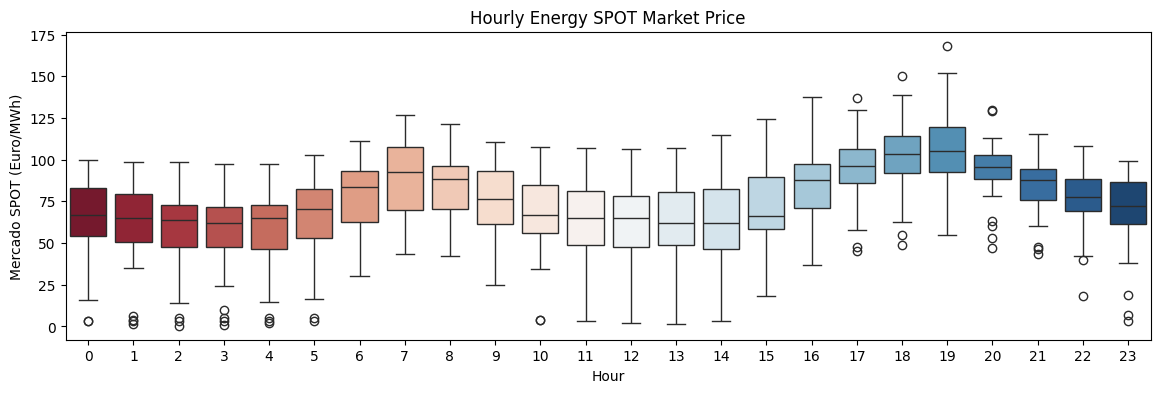

In [97]:
import warnings
plt.figure(figsize=(14,4))
warnings.filterwarnings('ignore')
MSpot = df[df['name']=='Mercado SPOT'].drop(columns=['id','geo_id','geo_name'])
MSpot.set_index('datetime', inplace=True)
MSpot['Hour'] = MSpot.index.hour
MSpot.resample('H')
sns.boxplot(MSpot,x='Hour', y='value', palette='RdBu')
plt.title('Hourly Energy SPOT Market Price')
plt.ylabel('Mercado SPOT (Euro/MWh)')
plt.show()


We can observe a clear pattern in the energy price: it tends to be higher in the morning and evening. This creates an opportunity to sell energy and generate profit, or to purchase energy when the price is low to minimize costs.

# 1. Data Exploration and Preprocessing

Descriptive Statistics

In [98]:
df.groupby('name')['value'].describe().T

name   Hidráulica UGH  Mercado SPOT      Nuclear  Previsión diaria  \
count     2976.000000    744.000000  2930.000000       2976.000000   
mean      1172.488601     74.100094  1777.841433      28213.715390   
std        457.773994     27.921106   820.843067       4831.410334   
min        301.425000      0.430000   579.000000      17934.000000   
25%        796.025000     58.500000  1003.400000      23867.000000   
50%       1176.925000     75.950000  2012.500000      29035.500000   
75%       1523.575000     92.682500  2017.100000      32323.500000   
max       2171.575000    168.350000  3032.800000      38313.000000   

name   Previsión eólica  Solar fotovoltaica  
count       2976.000000         2976.000000  
mean        7562.785618         2414.356384  
std         4397.665803         3746.842803  
min          662.000000            0.000000  
25%         3890.000000            0.000000  
50%         6491.500000            0.000000  
75%        10926.000000         4357.750000  
max        18883.000000        12488.900000

The energy price can rise as high as 168.35 €/MWh. Conversely, it can fall to as low as 0.40 €/MWh 

## Trend and Seasonality

In [99]:
# import library to detect trends and seasonality
df_copy = df.copy()
df_copy.drop(['id','geo_name','geo_id'],inplace=True, axis=1)
df_copy.set_index('datetime',inplace=True)
df_copy.index = pd.to_datetime(df_copy.index)
df_copy['Hour'] = df_copy.index.hour
df_copy.set_index('Hour', inplace=True)
import statsmodels.tsa.seasonal as STL
df_market_price = df_copy[df_copy['name'] == 'Mercado SPOT']

ses_decomp = STL.seasonal_decompose(df_market_price['value'], model='additive', period=96)

# --- Create Subplots using MATPLOT ---
'''
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
ses_decomp.trend.plot(ax=ax1,ylabel = "trend")
ses_decomp.resid.plot(ax=ax2,ylabel = "seasoanlity")
ses_decomp.seasonal.plot(ax=ax3,ylabel = "residual")
plt.tight_layout()
plt.show() '''

import plotly.subplots as sp
# --- Create Subplots ---
fig = sp.make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    subplot_titles=("Trend", "Seasonality", "Residual")
)

# Trend
fig.add_trace(
    go.Scatter(
        x=df_market_price.index,
        y=ses_decomp.trend,
        mode="lines",
        name="Trend"
    ),
    row=1, col=1
)

# Seasonality
fig.add_trace(
    go.Scatter(
        x=df_market_price.index,
        y=ses_decomp.seasonal,
        mode="lines",
        name="Seasonality"
    ),
    row=2, col=1
)

# Residual
fig.add_trace(
    go.Scatter(
        x=df_market_price.index,
        y=ses_decomp.resid,
        mode="lines",
        name="Residual"
    ),
    row=3, col=1
)

# Layout
fig.update_layout(
    height=900,
    title="Seasonal Decomposition (Additive Model)",
    showlegend=False,
    template="plotly_white"
)

fig.update_xaxes(title_text="Time", row=3, col=1)
fig.update_yaxes(title_text="Trend", row=1, col=1)
fig.update_yaxes(title_text="Seasonality", row=2, col=1)
fig.update_yaxes(title_text="Residual", row=3, col=1)

fig.show()

From the graph above, we can observe seasonality in the Energy Spot Market Price. Although the daily 24-hour seasonality is not perfectly consistent, a clear pattern emerges: the Energy Spot Market Price tends to increase just before noon and again in the evening.  The residual captures anomalies, outliers, and other unexpected events.

## Missing Values in the Dataset

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15578 entries, 0 to 15577
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   datetime  15578 non-null  datetime64[ns, UTC]
 1   id        15578 non-null  int64              
 2   name      15578 non-null  object             
 3   geo_id    15578 non-null  int64              
 4   geo_name  15578 non-null  object             
 5   value     15578 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(2)
memory usage: 730.3+ KB


In [101]:
df.isna().sum()

datetime    0
id          0
name        0
geo_id      0
geo_name    0
value       0
dtype: int64

<Axes: >

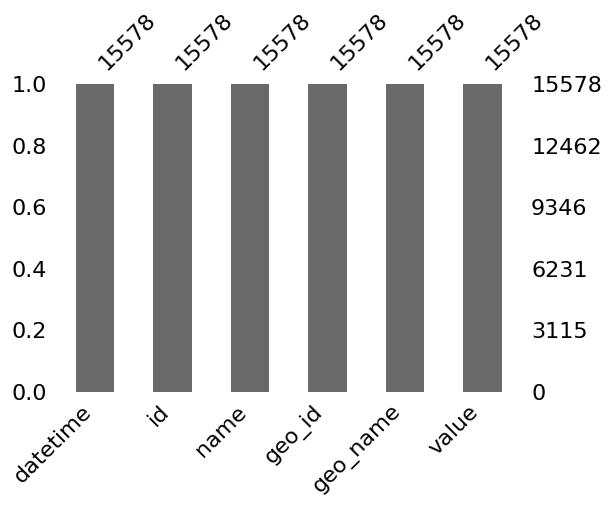

In [102]:
import missingno as msno
msno.bar(df, figsize=(6,4))

For the columns above, there aren't any missing values.

In [103]:
df.isnull().sum()

datetime    0
id          0
name        0
geo_id      0
geo_name    0
value       0
dtype: int64

There are no missing values in the dataset. If any missing values occur, they can be replaced using interpolation, forward fill, backward fill, etc.

## Anomalies

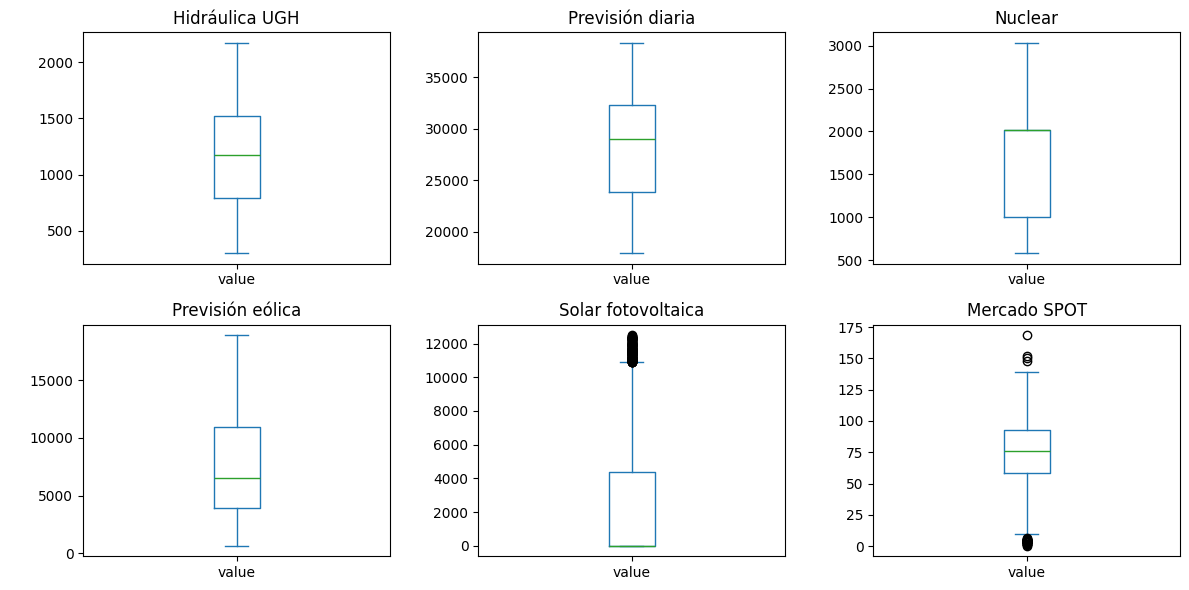

In [104]:
df_value = df[['name', 'value']]
unique_names = df_value['name'].unique()
n = len(unique_names)

# Create subplots
fig, axes = plt.subplots(2, int((n + 1) / 2), figsize=(12, 6))
axes = axes.flatten()  

for i, name in enumerate(unique_names):
    subset = df_value.loc[df_value['name'] == name, 'value']
    subset.plot(kind='box', ax=axes[i], title=f'{name}')
    axes[i].set_ylabel(f" ")

plt.tight_layout()
plt.show()


Several data points lie outside the whiskers of the boxplot, and these are considered outliers. Based on this criterion, both Solar Photovoltaic and Mercado Spot contain outliers.

## Removing Anomalies

Here, I used the Interquartile Range (IQR) method to remove anomalies, as illustrated in the boxplot above. Any data points that fall above the upper bound or below the lower bound are removed from the dataset.

In [105]:
def remove_anomalies (data_frame_, column):
    data_frame = data_frame_.copy()
    for name_ in ['Solar fotovoltaica','Mercado SPOT']:
        df_spot_market = data_frame[data_frame['name']== name_]
        Q1 = df_spot_market[column].quantile(0.25)
        Q3 = df_spot_market[column].quantile(0.75)
        IQR = Q3-Q1
        print('Quartile 1:', '|', Q1, 'Quartile 3:', Q3)
        print('Lower Bound:',Q1-1.5*IQR,'|', 'Upper Bound:', Q3+1.5*IQR)

        lower_bound = Q1 - 1.5 * IQR
        Upper_bound = Q3 + 1.5 * IQR

        Mask = (data_frame['name']==name_) & (data_frame['value']>Upper_bound) | (data_frame['name']==name_) & (data_frame['value']<lower_bound)
        data_frame.loc[Mask,'value'] = pd.NA

    return data_frame

removed_anomalies = remove_anomalies(df,'value')

Quartile 1: | 0.0 Quartile 3: 4357.75
Lower Bound: -6536.625 | Upper Bound: 10894.375
Quartile 1: | 58.5 Quartile 3: 92.6825
Lower Bound: 7.226249999999993 | Upper Bound: 143.95625


In [106]:
df[df['name'] == 'Mercado SPOT'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 744 entries, 8 to 15565
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   datetime  744 non-null    datetime64[ns, UTC]
 1   id        744 non-null    int64              
 2   name      744 non-null    object             
 3   geo_id    744 non-null    int64              
 4   geo_name  744 non-null    object             
 5   value     744 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(2)
memory usage: 40.7+ KB


In [107]:
removed_anomalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15578 entries, 0 to 15577
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   datetime  15578 non-null  datetime64[ns, UTC]
 1   id        15578 non-null  int64              
 2   name      15578 non-null  object             
 3   geo_id    15578 non-null  int64              
 4   geo_name  15578 non-null  object             
 5   value     15410 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(2)
memory usage: 730.3+ KB


Box Plot

The boxplot below illustrates the presence of outliers in the dataset. After removing the anomalies in the spot market price, the data points outside the whiskers are no longer visible.

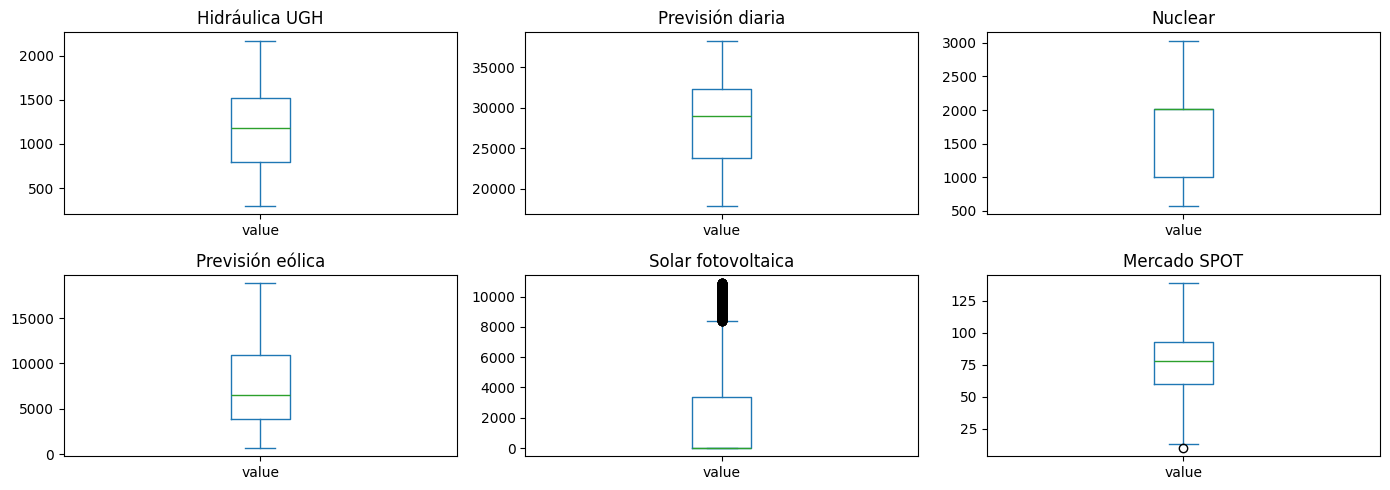

In [108]:
df_value = removed_anomalies[['name','value']]
unique_names = removed_anomalies['name'].unique()
n = len(unique_names)
fig, axes = plt.subplots(2, int(n/2), figsize = (14,5))
axes = axes.flatten()
for idx, names in enumerate(unique_names):
    subset = df_value.loc[df_value['name'] ==names,'value']
    subset.plot(kind ='box', ax=axes[idx], title =f'{names}')

plt.tight_layout()
plt.show()

Histogram

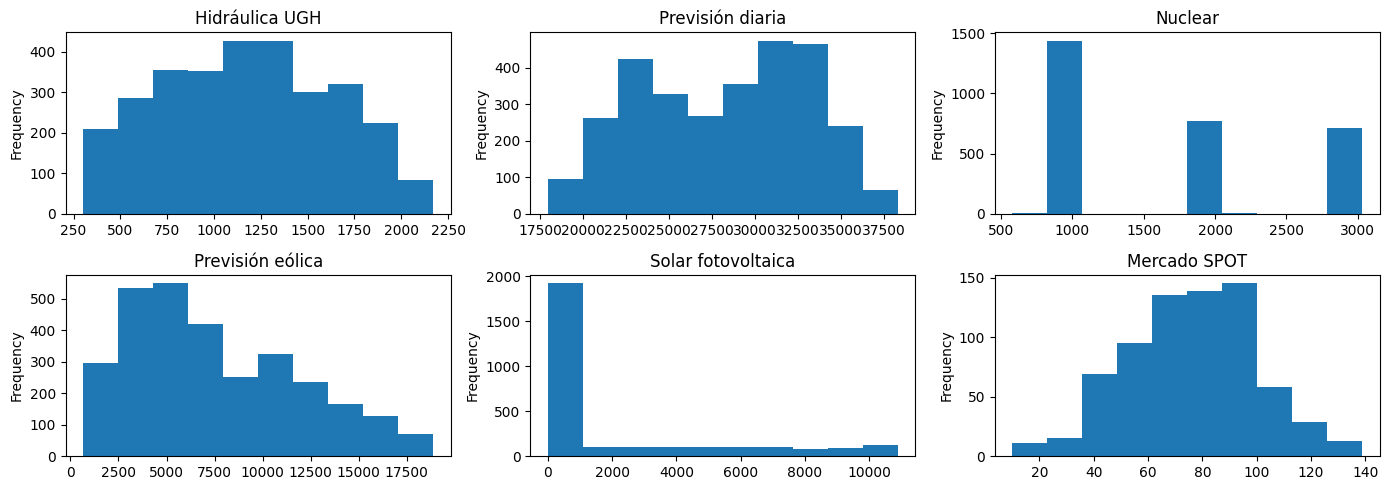

In [109]:
df_value = removed_anomalies[['name','value']]
unique_names = removed_anomalies['name'].unique()
n = len(unique_names)
fig, axes = plt.subplots(2, int(n/2), figsize = (14,5))
axes = axes.flatten()
for idx, names in enumerate(unique_names):
    subset = df_value.loc[df_value['name'] ==names,'value']
    subset.plot(kind ='hist', ax=axes[idx], title =f'{names}', bins = 10, )
plt.tight_layout()
plt.show()

Pivot Table: 

I pivoted the table below because I assumed that hydropower, wind energy, nuclear energy, solar energy, predicted energy generation and the predicted wind energy generation affect the actual spot market price. According to the merit-order principle, the market clearing price is determined by the operational cost of the generation units required to meet demand. Therefore, we treat the different types of energy generation as independent variables and the spot market price as the dependent variable.

In [110]:
pivot = removed_anomalies.pivot_table(columns='name', index='datetime', values='value')

# Ensure index is datetime & remove timezone
pivot.index = pivot.index.strftime('%Y-%m-%d %H:%M:%S')

## Handling Missing Values

Is there any null values in the pivot table? 

In [111]:
print('Null values in the table\n',pivot.isnull().sum())
print('\n--------\n')

Null values in the table
 name
Hidráulica UGH           0
Mercado SPOT          2267
Nuclear               2232
Previsión diaria         0
Previsión eólica         0
Solar fotovoltaica     133
dtype: int64

--------



We see missing values in the pivoted table because the energy generation data are sampled every 15 minutes, while the actual market spot prices and nuclear energy generation are recorded hourly. In addition, the anomalies removed earlier were replaced with NaN values, which causes both the PV generation column and the market spot price column to have missing values.

In [112]:
Hourly_pivot = pivot.copy()

## Remove null values using methods such as bfill, ffill, or fillna.

I assume that nuclear generation remains constant over the next 15 minutes; therefore, the forward-fill (ffill) method was used to fill the missing values.

Similarly, the missing values in the solar PV generation and the actual spot market prices were also filled using the forward-fill method.

In [113]:
pivot['Nuclear'].ffill(inplace=True)
pivot['Mercado SPOT'].ffill(inplace=True)
pivot['Solar fotovoltaica'].ffill(inplace=True)
# Export to Excel
pivot.to_excel('pivot.xlsx')
pivot

name                 Hidráulica UGH  Mercado SPOT  Nuclear  Previsión diaria  \
datetime                                                                       
2023-12-31 23:00:00         626.950         63.33   1779.3           21981.0   
2023-12-31 23:15:00         647.975         63.33   1779.3           21863.0   
2023-12-31 23:30:00         625.850         63.33   1779.3           21807.0   
2023-12-31 23:45:00         625.850         63.33   1779.3           21767.0   
2024-01-01 00:00:00         663.125         50.09   1779.3           22640.0   
...                             ...           ...      ...               ...   
2024-01-31 21:45:00        1673.050         85.00   1779.3           29007.0   
2024-01-31 22:00:00        1588.950         77.52   1779.3           28070.0   
2024-01-31 22:15:00        1547.425         77.52   1779.3           27495.0   
2024-01-31 22:30:00        1547.425         77.52   1779.3           27003.0   
2024-01-31 22:45:00        1496.925         77.52   1779.3           26566.0   

name                 Previsión eólica  Solar fotovoltaica  
datetime                                                   
2023-12-31 23:00:00            5218.0                 0.0  
2023-12-31 23:15:00            5198.0                 0.0  
2023-12-31 23:30:00            5175.0                 0.0  
2023-12-31 23:45:00            5147.0                 0.0  
2024-01-01 00:00:00            5299.0                 0.0  
...                               ...                 ...  
2024-01-31 21:45:00            4059.0                 0.0  
2024-01-31 22:00:00            4027.0                 0.0  
2024-01-31 22:15:00            4090.0                 0.0  
2024-01-31 22:30:00            4148.0                 0.0  
2024-01-31 22:45:00            4199.0                 0.0  

[2976 rows x 6 columns]

In [114]:
pivot.isna().sum()

name
Hidráulica UGH        0
Mercado SPOT          0
Nuclear               0
Previsión diaria      0
Previsión eólica      0
Solar fotovoltaica    0
dtype: int64

## Correlation

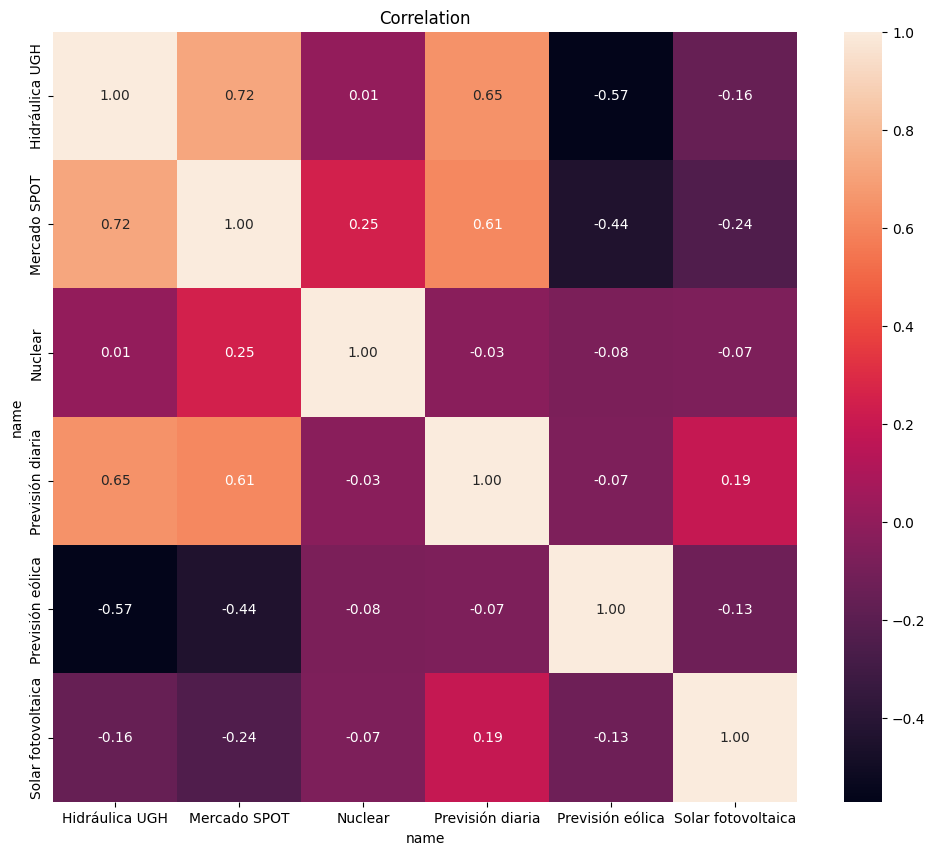

In [115]:
# Calculate the correlation matrix
corr = pivot.iloc[:,:].corr(method='pearson') 

# Plot Heat Map,
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f" )
plt.title('Correlation')
plt.show()

This heatmap shows a high correlation between the market spot price and the predicted energy generation and the Hydropower generation.

## Feature Engineering

**HOUR**: At different times of the day, the intensity of solar and wind energy production varies. For instance, solar power reaches its maximum output around noon, while wind tends to blow more strongly in the evening and at night. We assume that during these peak periods of solar and wind production, their influence on the market price becomes more noticeable.

**MONTH**: Similarly, due to seasonal and weather variations across different months, energy production becomes erratic and depends on the time of year. For example, summer months receive more sunlight, whereas winter months have limited sunlight.

**Cyclical encoding**: Temporal features such as hours or months are cyclical, but numeric representations treat the gap between, for example, hour 23 and hour 0 as large. Encoding these features using sine and cosine preserves their cyclical nature and prevents misleading gaps.

In [116]:
pivot.index = pd.to_datetime(pivot.index)

In [117]:
# function to create temporal features

def temporal_features (dataframe):
    dataframe['Hour'] = dataframe.index.hour
    dataframe['Month'] = dataframe.index.month
    dataframe['hour_of_day'] = dataframe.index.hour / 24.0
    dataframe['hour_of_day_sin'] = np.sin(2 * np.pi * dataframe['hour_of_day'])
    dataframe['hour_of_day_cos'] = np.cos(2 * np.pi * dataframe['hour_of_day'])
    return dataframe

In [118]:
pivot = temporal_features(pivot)

In [119]:
pivot.dropna(inplace=True)
pivot

name                 Hidráulica UGH  Mercado SPOT  Nuclear  Previsión diaria  \
datetime                                                                       
2023-12-31 23:00:00         626.950         63.33   1779.3           21981.0   
2023-12-31 23:15:00         647.975         63.33   1779.3           21863.0   
2023-12-31 23:30:00         625.850         63.33   1779.3           21807.0   
2023-12-31 23:45:00         625.850         63.33   1779.3           21767.0   
2024-01-01 00:00:00         663.125         50.09   1779.3           22640.0   
...                             ...           ...      ...               ...   
2024-01-31 21:45:00        1673.050         85.00   1779.3           29007.0   
2024-01-31 22:00:00        1588.950         77.52   1779.3           28070.0   
2024-01-31 22:15:00        1547.425         77.52   1779.3           27495.0   
2024-01-31 22:30:00        1547.425         77.52   1779.3           27003.0   
2024-01-31 22:45:00        1496.925         77.52   1779.3           26566.0   

name                 Previsión eólica  Solar fotovoltaica  Hour  Month  \
datetime                                                                 
2023-12-31 23:00:00            5218.0                 0.0    23     12   
2023-12-31 23:15:00            5198.0                 0.0    23     12   
2023-12-31 23:30:00            5175.0                 0.0    23     12   
2023-12-31 23:45:00            5147.0                 0.0    23     12   
2024-01-01 00:00:00            5299.0                 0.0     0      1   
...                               ...                 ...   ...    ...   
2024-01-31 21:45:00            4059.0                 0.0    21      1   
2024-01-31 22:00:00            4027.0                 0.0    22      1   
2024-01-31 22:15:00            4090.0                 0.0    22      1   
2024-01-31 22:30:00            4148.0                 0.0    22      1   
2024-01-31 22:45:00            4199.0                 0.0    22      1   

name                 hour_of_day  hour_of_day_sin  hour_of_day_cos  
datetime                                                            
2023-12-31 23:00:00     0.958333        -0.258819         0.965926  
2023-12-31 23:15:00     0.958333        -0.258819         0.965926  
2023-12-31 23:30:00     0.958333        -0.258819         0.965926  
2023-12-31 23:45:00     0.958333        -0.258819         0.965926  
2024-01-01 00:00:00     0.000000         0.000000         1.000000  
...                          ...              ...              ...  
2024-01-31 21:45:00     0.875000        -0.707107         0.707107  
2024-01-31 22:00:00     0.916667        -0.500000         0.866025  
2024-01-31 22:15:00     0.916667        -0.500000         0.866025  
2024-01-31 22:30:00     0.916667        -0.500000         0.866025  
2024-01-31 22:45:00     0.916667        -0.500000         0.866025  

[2976 rows x 11 columns]

Text(0.5, 1.0, 'Hourly Energy Price')

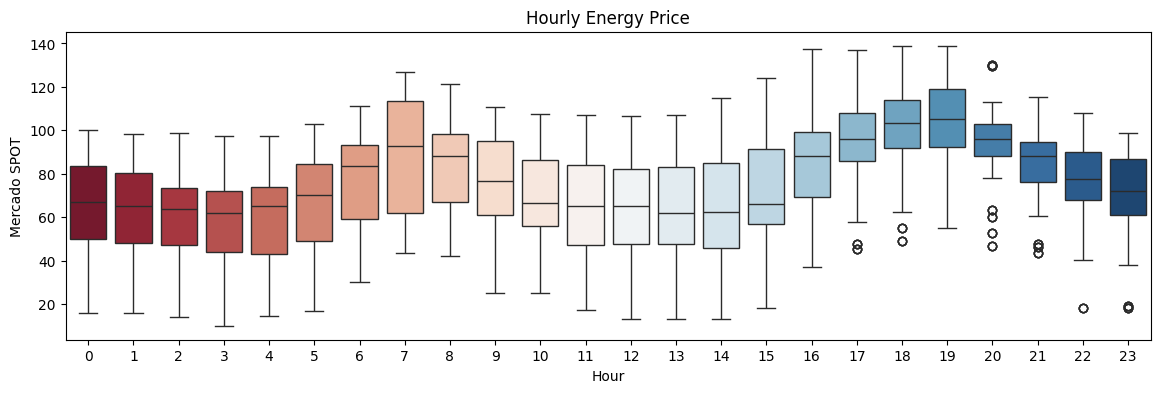

In [120]:
plt.figure(figsize=(14,4))
sns.boxplot(pivot, x= 'Hour', y= 'Mercado SPOT', palette='RdBu')
plt.title('Hourly Energy Price')

# 2. Predictive Modeling

This first model predicts the energy price every fifteen minutes. Later in the work, I also developed a prediction model to predict energy price on an hourly basis.

In [121]:
# import libraries for building machine learning model

from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
import joblib

## Splitting the data

In [122]:
# Splitting train and test data
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV, check_cv, cross_val_score, TimeSeriesSplit

df_ML = pivot

# Features X, Target y
X = df_ML.drop(['Mercado SPOT'], axis=1)   #features
y = df_ML['Mercado SPOT']   #target
Train_split = 0.2   #20% of the data is allocated for testing.

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=Train_split, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=Train_split, shuffle=False)



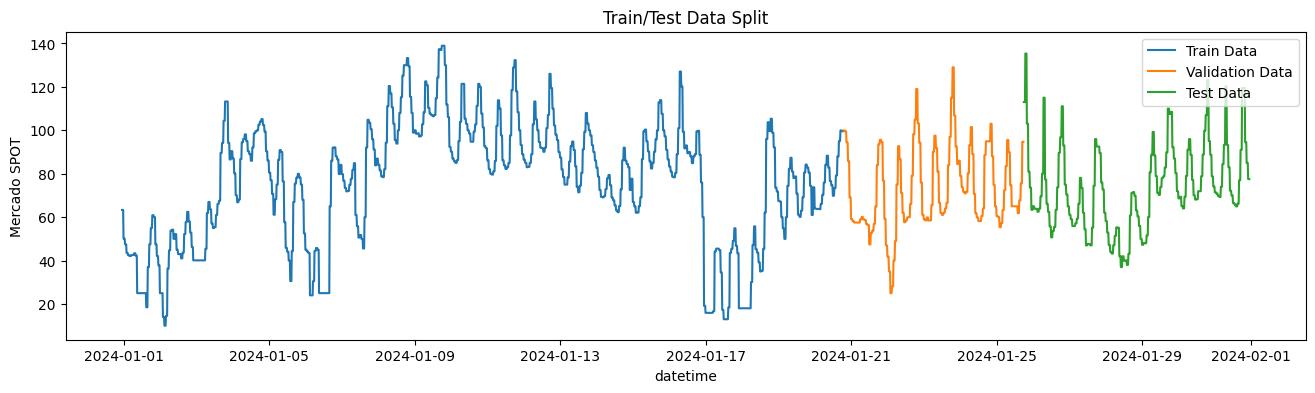

In [123]:
# plot training, validation, and testing data
plt.rcParams['figure.figsize'] = [16, 4]
sns.lineplot(x= X_train.index, y=y_train, label = 'Train Data')
sns.lineplot(x=X_val.index, y=y_val, label = 'Validation Data')
sns.lineplot(x=X_test.index, y= y_test, label ='Test Data')
plt.legend(loc='upper right')
plt.title('Train/Test Data Split')
plt.show()

## Model Building and Evaluation

In [124]:
# num of folds and error metrics
num_of_folds = 5
error_metrics= {'neg_mean_squared_error','neg_mean_absolute_error','r2'}
metric_short = {'neg_mean_squared_error','neg_mean_absolute_error','r2'}


# models
models = {
    ('RFR', RandomForestRegressor()),
    ('XGB', XGBRegressor()), 
    ('LR', LinearRegression()),
    ('GBR', GradientBoostingRegressor()),
    ('DTR', DecisionTreeRegressor()),
}

##### Evaluation metric:  neg_mean_squared_error

Training model: LR with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: LinearRegression(), neg_mean_squared_error Men: -1948.7967, std:3378.4863


Training model: GBR with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: GradientBoostingRegressor(), neg_mean_squared_error Men: -311.9844, std:192.2243


Training model: RFR with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: RandomForestRegressor(), neg_mean_squared_error Men: -287.9805, std:162.0952


Training model: DTR with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: DecisionTreeRegressor(), neg_mean_squared_error Men: -338.5647, std:160.4030


Training model: XGB with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
         

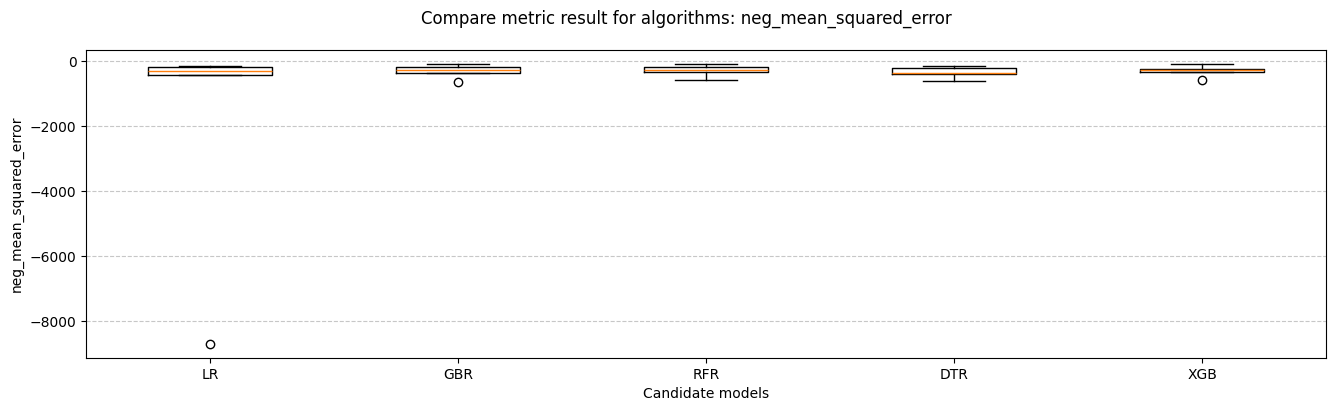

##### Evaluation metric:  neg_mean_absolute_error

Training model: LR with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: LinearRegression(), neg_mean_absolute_error Men: -26.5723, std:26.5883


Training model: GBR with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: GradientBoostingRegressor(), neg_mean_absolute_error Men: -13.5588, std:5.0968


Training model: RFR with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: RandomForestRegressor(), neg_mean_absolute_error Men: -13.4231, std:4.4461


Training model: DTR with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: DecisionTreeRegressor(), neg_mean_absolute_error Men: -14.3868, std:4.3597


Training model: XGB with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
            

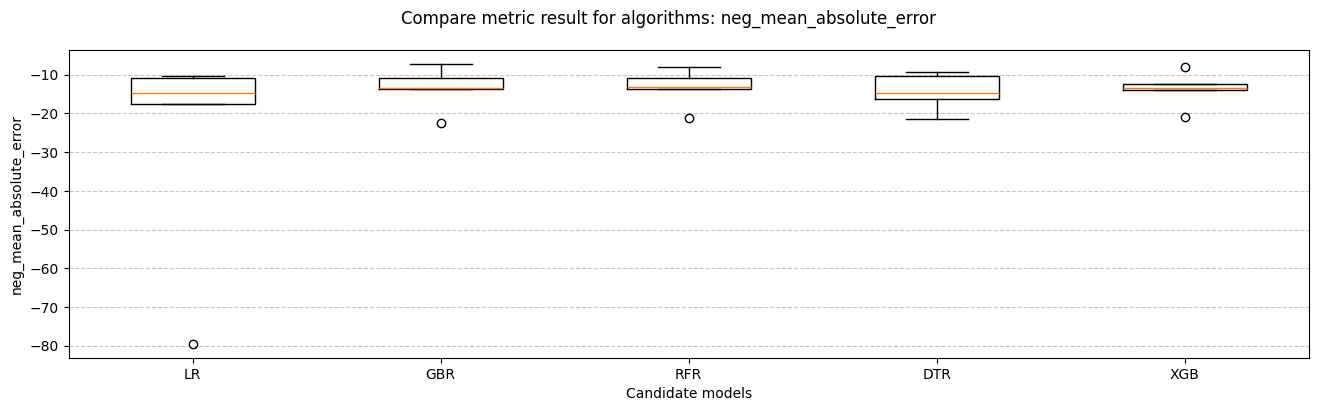

##### Evaluation metric:  r2

Training model: LR with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: LinearRegression(), r2 Men: -2.1475, std:5.0055


Training model: GBR with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: GradientBoostingRegressor(), r2 Men: 0.3777, std:0.2149


Training model: RFR with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: RandomForestRegressor(), r2 Men: 0.4043, std:0.1578


Training model: DTR with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: DecisionTreeRegressor(), r2 Men: 0.2247, std:0.1710


Training model: XGB with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
           

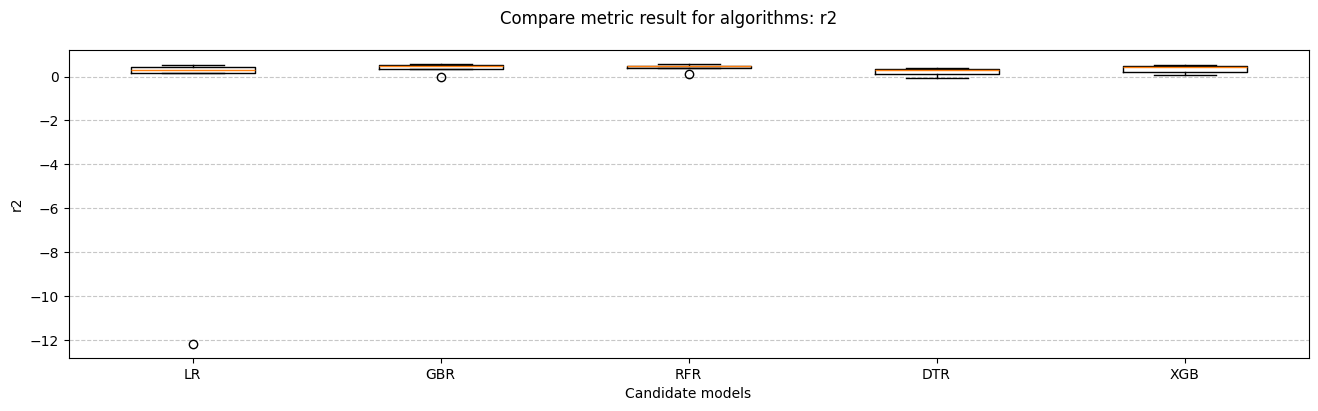

In [125]:
for scoring in error_metrics:
    results =[] # list of metric results
    msg=[] #list of summary of results
    names =[] #list of name of the models
    print('##### Evaluation metric: ', scoring)

    for name, model in models:
        print(f'\nTraining model: {name} with {scoring}...')
        cross_validation =TimeSeriesSplit(n_splits=num_of_folds)

        #start the cross-validation process and print verbose output
        print(f'Perfroming TimeSeriesSplit with {num_of_folds} folds...')

        cv_results = cross_val_score(model,X_train,y_train,cv=cross_validation,scoring=scoring)

        print(f'Model: {model}, {scoring} Men: {cv_results.mean():.4f}, std:{cv_results.std():.4f}\n')

        results.append(cv_results)
        names.append(name)
        resume = (name,cv_results.mean(), cv_results.std())
        msg.append(resume)

 # Compare results between algorithms
    fig = plt.figure()
    fig.suptitle('Compare metric result for algorithms: %s' %scoring)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Candidate models')
    ax.set_ylabel('%s' %scoring)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    # Show a grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

    results = []

## Best Model Hyperparameters Adjustment

In [126]:
model = RandomForestRegressor()
scoring='r2'
params = {
    # Number of trees in random forest
    'n_estimators': [100, 500],  # default=100
    'max_depth': [2, None],  #deafult = None
}


# Search for the best combination of hyperparameters
cross_validation = TimeSeriesSplit(n_splits=5)
my_cv = cross_validation.split(X_val)
gsearch = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, cv=my_cv, verbose=3)
gsearch.fit(X_val, y_val)

# Print best Result
print("Best result: %f using the following hyperparameters %s" % (gsearch.best_score_, gsearch.best_params_))
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
params = gsearch.cv_results_['params']

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....max_depth=2, n_estimators=100;, score=0.527 total time=   0.0s
[CV 2/5] END .....max_depth=2, n_estimators=100;, score=0.587 total time=   0.0s
[CV 3/5] END .....max_depth=2, n_estimators=100;, score=0.264 total time=   0.0s
[CV 4/5] END .....max_depth=2, n_estimators=100;, score=0.479 total time=   0.0s
[CV 5/5] END .....max_depth=2, n_estimators=100;, score=0.470 total time=   0.0s
[CV 1/5] END .....max_depth=2, n_estimators=500;, score=0.510 total time=   0.1s
[CV 2/5] END .....max_depth=2, n_estimators=500;, score=0.586 total time=   0.1s
[CV 3/5] END .....max_depth=2, n_estimators=500;, score=0.260 total time=   0.2s
[CV 4/5] END .....max_depth=2, n_estimators=500;, score=0.409 total time=   0.2s
[CV 5/5] END .....max_depth=2, n_estimators=500;, score=0.472 total time=   0.2s
[CV 1/5] END ..max_depth=None, n_estimators=100;, score=0.491 total time=   0.0s
[CV 2/5] END ..max_depth=None, n_estimators=100;,

## Final Evaluation of the Model

In [127]:
# make prediction on the test dataset 
final_model_v1 = RandomForestRegressor(n_estimators=100, max_depth=None) # Model with the optimal parameters
final_model_v1.fit(X_train, y_train)
y_predict_v1 = final_model_v1.predict(X_test) # Making prediction

Evaluation Metrics for this final model (MAE, RMSE)

In [128]:
# Calculating MAE
MAE_minute_1 = mean_absolute_error(y_test, y_predict_v1)

# Calculating RMSE
MSE = mean_squared_error(y_test, y_predict_v1)
RMSE_minute_1 = np.sqrt(MSE)

print('Evaluation Metrics Results.....')
print('MAE: ', MAE_minute_1)
print('RMSE: ', RMSE_minute_1)

Evaluation Metrics Results.....
MAE:  21.19539194630875
RMSE:  23.169180177947364


Feature Importance

The following plot shows how much each input variable (feature) contributes to the model’s predictions. In other words, it indicates which features the model relies on the most when making decisions.

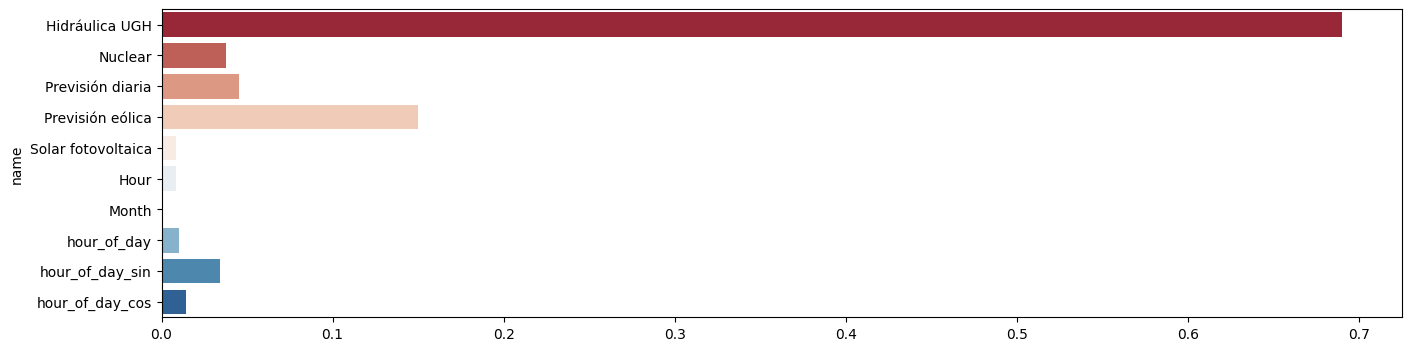

In [129]:
importances = final_model_v1.feature_importances_    #retrieve the feature importance score
features = X.columns  #the columns names

sns.barplot(x=importances, y=features, palette='RdBu')
plt.show()

In this prediction model, the hydropower generation feature tends to have a significant impact.

## Plot the Predictions Vs the Real Values

In [130]:
def  prediction_plot (y_test_data, y_predict_data):
    import plotly.graph_objects as go
    fig = go.Figure()

    # plotting the actual spot market energy price
    fig.add_trace(go.Scatter(
        x=y_test_data.index, y=y_test_data, mode = 'lines',
        name='True values', line = dict(color='blue', width=1.5)
    ))

    # plotting the predicted spot market energy price
    fig.add_trace(go.Scatter(
        x=y_test_data.index, y=y_predict_data, mode ='lines',
        name='Predicted values', line = dict(color='red', width=1.5, dash='dot')
    ))

    # Update layout for a more beautiful plot
    fig.update_layout(
        title='True vs Predicted Spot Market Energy Price',
        xaxis_title='Date/Time',
        yaxis_title='Energy Price (Euro/MWh)',
        template='plotly',  # dark theme, can change to 'plotly' for light theme
        hovermode='x unified',  # hover over to show values for both lines at a time
        legend=dict(
            x=0.01, y=0.99,  # position of legend
            traceorder='normal',
            font=dict(family="Arial", size=12, color="white"),
            bgcolor='rgba(0, 0, 0, 0.3)',
            bordercolor='white',
            borderwidth=1
        ),
    
    
    )

    # Show the plot
    fig.show()


In [131]:
prediction_plot(y_test, y_predict_v1)

Pipeline

In [132]:
make_pipeline(final_model_v1)

Pipeline(steps=[('randomforestregressor', RandomForestRegressor())])

In [133]:
joblib.dump(final_model_v1,'Energy_price_prediction_v1')

['Energy_price_prediction_v1']

## Hourly Prediction

In the prediction model above, the data were sampled every 15 minutes. Therefore, the predictions are made at 15-minute intervals. However, we are now repeating the same prediction using data in an hourly format to develop a model that predicts the hourly energy price.

In [134]:
Hourly_pivot.index = pd.to_datetime(Hourly_pivot.index)

The Energy Spot Market price is already provided on an hourly basis, but the energy-generation data from different sources is not. To convert these data into an hourly format, I resampled the DataFrame so that each hour contains the average value of the four fifteen-minute intervals.

In [135]:
Hourly_pivot= Hourly_pivot.resample('H').mean()

In [136]:
Hourly_pivot

name                 Hidráulica UGH  Mercado SPOT  Nuclear  Previsión diaria  \
datetime                                                                       
2023-12-31 23:00:00       631.65625         63.33   1779.3          21854.50   
2024-01-01 00:00:00       637.81250         50.09   1779.3          21981.25   
2024-01-01 01:00:00       529.62500         47.50   1779.3          20403.00   
2024-01-01 02:00:00       469.40000         43.50   1779.3          18777.00   
2024-01-01 03:00:00       418.78750         42.50   1779.3          18150.50   
...                             ...           ...      ...               ...   
2024-01-31 18:00:00      2033.02500        119.47   1779.3          33612.50   
2024-01-31 19:00:00      2044.30625           NaN   1779.3          34230.75   
2024-01-31 20:00:00      1980.90000         94.54   1779.3          33363.00   
2024-01-31 21:00:00      1827.70000         85.00   1779.3          30290.00   
2024-01-31 22:00:00      1545.18125         77.52   1779.3          27283.50   

name                 Previsión eólica  Solar fotovoltaica  
datetime                                                   
2023-12-31 23:00:00           5184.50                 0.0  
2024-01-01 00:00:00           5243.25                 0.0  
2024-01-01 01:00:00           5323.50                 0.0  
2024-01-01 02:00:00           5343.75                 0.0  
2024-01-01 03:00:00           5156.25                 0.0  
...                               ...                 ...  
2024-01-31 18:00:00           2794.25                 0.0  
2024-01-31 19:00:00           3215.00                 0.0  
2024-01-31 20:00:00           3573.00                 0.0  
2024-01-31 21:00:00           3946.75                 0.0  
2024-01-31 22:00:00           4116.00                 0.0  

[744 rows x 6 columns]

In [137]:
Hourly_pivot.isna().sum()

name
Hidráulica UGH         0
Mercado SPOT          35
Nuclear                0
Previsión diaria       0
Previsión eólica       0
Solar fotovoltaica    26
dtype: int64

**Missing Values**: The missing values were replaced using the forward fill method, assuming that the energy price in the next hour will be the same as the current price.

In [138]:
Hourly_pivot['Mercado SPOT'].ffill(inplace=True)
Hourly_pivot['Solar fotovoltaica'].ffill(inplace=True)
# Export to Excel
Hourly_pivot.to_excel('Hourly_pivot.xlsx')
Hourly_pivot

name                 Hidráulica UGH  Mercado SPOT  Nuclear  Previsión diaria  \
datetime                                                                       
2023-12-31 23:00:00       631.65625         63.33   1779.3          21854.50   
2024-01-01 00:00:00       637.81250         50.09   1779.3          21981.25   
2024-01-01 01:00:00       529.62500         47.50   1779.3          20403.00   
2024-01-01 02:00:00       469.40000         43.50   1779.3          18777.00   
2024-01-01 03:00:00       418.78750         42.50   1779.3          18150.50   
...                             ...           ...      ...               ...   
2024-01-31 18:00:00      2033.02500        119.47   1779.3          33612.50   
2024-01-31 19:00:00      2044.30625        119.47   1779.3          34230.75   
2024-01-31 20:00:00      1980.90000         94.54   1779.3          33363.00   
2024-01-31 21:00:00      1827.70000         85.00   1779.3          30290.00   
2024-01-31 22:00:00      1545.18125         77.52   1779.3          27283.50   

name                 Previsión eólica  Solar fotovoltaica  
datetime                                                   
2023-12-31 23:00:00           5184.50                 0.0  
2024-01-01 00:00:00           5243.25                 0.0  
2024-01-01 01:00:00           5323.50                 0.0  
2024-01-01 02:00:00           5343.75                 0.0  
2024-01-01 03:00:00           5156.25                 0.0  
...                               ...                 ...  
2024-01-31 18:00:00           2794.25                 0.0  
2024-01-31 19:00:00           3215.00                 0.0  
2024-01-31 20:00:00           3573.00                 0.0  
2024-01-31 21:00:00           3946.75                 0.0  
2024-01-31 22:00:00           4116.00                 0.0  

[744 rows x 6 columns]

In [139]:
#temporal features
#calling the function to create temporal features
Hourly_pivot = temporal_features(Hourly_pivot)

## Splitting Data

In [140]:
# Splitting train and test dataset
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV, check_cv, cross_val_score, TimeSeriesSplit
df_ML_hourly = Hourly_pivot

# Features X, Target y
X = df_ML_hourly.drop(['Mercado SPOT'], axis=1)   #features
y = df_ML_hourly['Mercado SPOT']   #target
Train_split = 0.2   #20% of the data is allocated for testing.

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=Train_split, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=Train_split, shuffle=False)


## Model Building and Evaluation

##### Evaluation metric:  neg_mean_squared_error

Training model: GBR with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: GradientBoostingRegressor(), neg_mean_squared_error Men: -305.2697, std:187.8999


Training model: RFR with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: RandomForestRegressor(), neg_mean_squared_error Men: -280.2119, std:170.2191


Training model: DTR with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: DecisionTreeRegressor(), neg_mean_squared_error Men: -392.3052, std:288.4635


Training model: LR with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: LinearRegression(), neg_mean_squared_error Men: -2187.0683, std:3857.9351


Training model: XGB with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
         

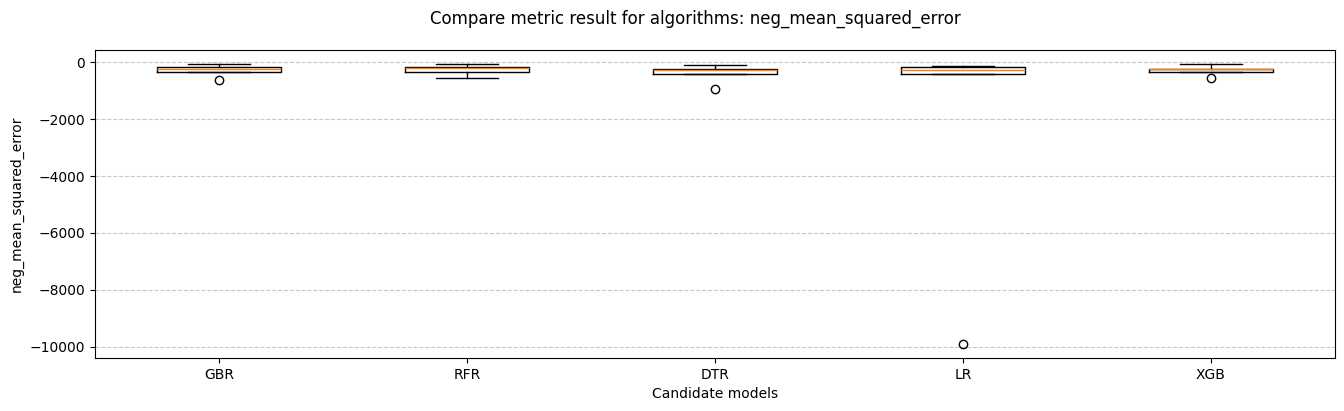

##### Evaluation metric:  neg_mean_absolute_error

Training model: GBR with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: GradientBoostingRegressor(), neg_mean_absolute_error Men: -13.2395, std:4.9427


Training model: RFR with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: RandomForestRegressor(), neg_mean_absolute_error Men: -12.8533, std:5.0574


Training model: DTR with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: DecisionTreeRegressor(), neg_mean_absolute_error Men: -14.6639, std:5.4739


Training model: LR with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: LinearRegression(), neg_mean_absolute_error Men: -27.5410, std:28.6272


Training model: XGB with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
            

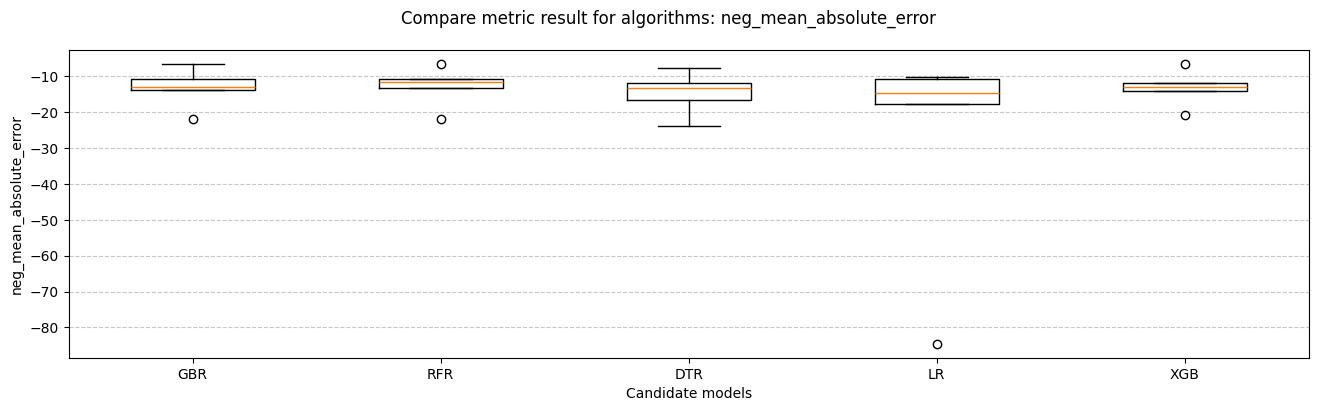

##### Evaluation metric:  r2

Training model: GBR with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: GradientBoostingRegressor(), r2 Men: 0.3779, std:0.2214


Training model: RFR with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: RandomForestRegressor(), r2 Men: 0.4214, std:0.2162


Training model: DTR with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: DecisionTreeRegressor(), r2 Men: 0.1939, std:0.3172


Training model: LR with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: LinearRegression(), r2 Men: -2.4659, std:5.6114


Training model: XGB with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
           

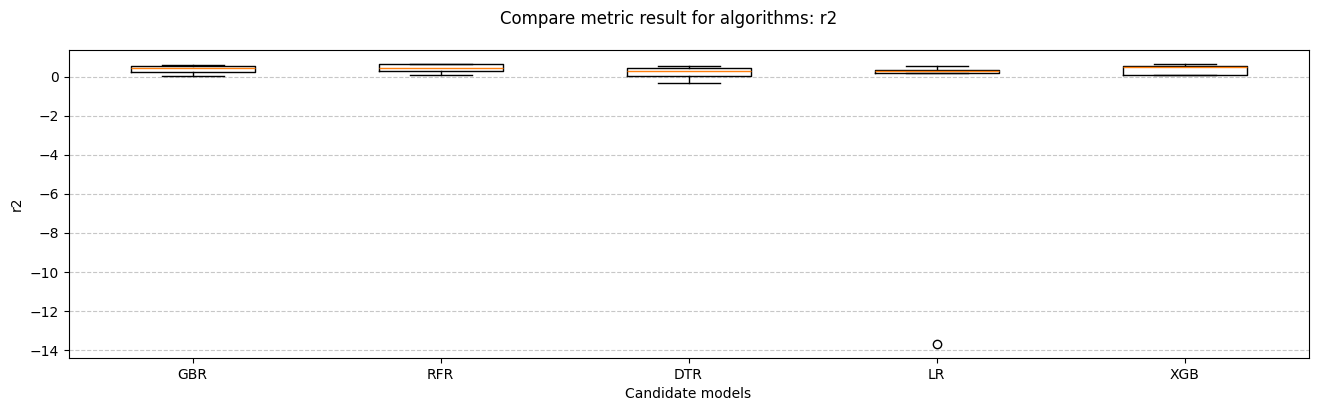

In [141]:

# num of folds and error metrics
num_of_folds = 5
error_metrics= {'neg_mean_squared_error','neg_mean_absolute_error','r2'}
metric_short = {'neg_mean_squared_error','neg_mean_absolute_error','r2'}


# models
models = {
    ('RFR', RandomForestRegressor()),
    ('XGB', XGBRegressor()), 
    ('LR', LinearRegression()),
    ('GBR', GradientBoostingRegressor()),
    ('DTR', DecisionTreeRegressor()),
}

for scoring in error_metrics:
    results =[] # list of metric results
    msg=[] #list of summary of results
    names =[] #list of name of the models
    print('##### Evaluation metric: ', scoring)

    for name, model in models:
        print(f'\nTraining model: {name} with {scoring}...')
        cross_validation =TimeSeriesSplit(n_splits=num_of_folds)

        #start the cross-validation process and print verbose output
        print(f'Perfroming TimeSeriesSplit with {num_of_folds} folds...')

        cv_results = cross_val_score(model,X_train,y_train,cv=cross_validation,scoring=scoring)

        print(f'Model: {model}, {scoring} Men: {cv_results.mean():.4f}, std:{cv_results.std():.4f}\n')

        results.append(cv_results)
        names.append(name)
        resume = (name,cv_results.mean(), cv_results.std())
        msg.append(resume)

 # Compare results between algorithms
    fig = plt.figure()
    fig.suptitle('Compare metric result for algorithms: %s' %scoring)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Candidate models')
    ax.set_ylabel('%s' %scoring)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    # Show a grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

    results = []

Best Model Hyperparameters Adjustment

In [142]:
model = RandomForestRegressor()
scoring='r2'
params = {
    # Number of trees in random forest
    'n_estimators': [100, 500],  # default=100
    'max_depth': [2, None],  #deafult = None
}


# Search for the best combination of hyperparameters
cross_validation = TimeSeriesSplit(n_splits=5)
my_cv = cross_validation.split(X_val)
gsearch = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, cv=my_cv, verbose=3)
gsearch.fit(X_val, y_val)

# Print best Result
print("Best result: %f using the following hyperparameters %s" % (gsearch.best_score_, gsearch.best_params_))
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
params = gsearch.cv_results_['params']

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....max_depth=2, n_estimators=100;, score=0.476 total time=   0.0s
[CV 2/5] END .....max_depth=2, n_estimators=100;, score=0.621 total time=   0.0s
[CV 3/5] END .....max_depth=2, n_estimators=100;, score=0.186 total time=   0.0s
[CV 4/5] END .....max_depth=2, n_estimators=100;, score=0.657 total time=   0.0s
[CV 5/5] END .....max_depth=2, n_estimators=100;, score=0.601 total time=   0.0s
[CV 1/5] END .....max_depth=2, n_estimators=500;, score=0.428 total time=   0.1s
[CV 2/5] END .....max_depth=2, n_estimators=500;, score=0.614 total time=   0.1s
[CV 3/5] END .....max_depth=2, n_estimators=500;, score=0.185 total time=   0.2s
[CV 4/5] END .....max_depth=2, n_estimators=500;, score=0.658 total time=   0.2s
[CV 5/5] END .....max_depth=2, n_estimators=500;, score=0.619 total time=   0.2s
[CV 1/5] END ..max_depth=None, n_estimators=100;, score=0.466 total time=   0.0s
[CV 2/5] END ..max_depth=None, n_estimators=100;,

## Final Evaluation of the Model

In [143]:
# make prediction on the test dataset
final_model_Hourly_v1 = RandomForestRegressor(n_estimators=500, max_depth=None) # Model with the optimal parameters
final_model_Hourly_v1.fit(X_train, y_train)
y_predict_Hourly_v1 = final_model_Hourly_v1.predict(X_test) # Making prediction

In [144]:
# Calculating MAE
MAE_hourly_1 = mean_absolute_error(y_test, y_predict_Hourly_v1)

# Calculating RMSE
MSE = mean_squared_error(y_test, y_predict_Hourly_v1)
RMSE_hourly_1 = np.sqrt(MSE)

print('Evaluation Metrics Results.....')
print('MAE: ', MAE_hourly_1)
print('RMSE: ', RMSE_hourly_1)

Evaluation Metrics Results.....
MAE:  19.814601476510035
RMSE:  21.520334888829158


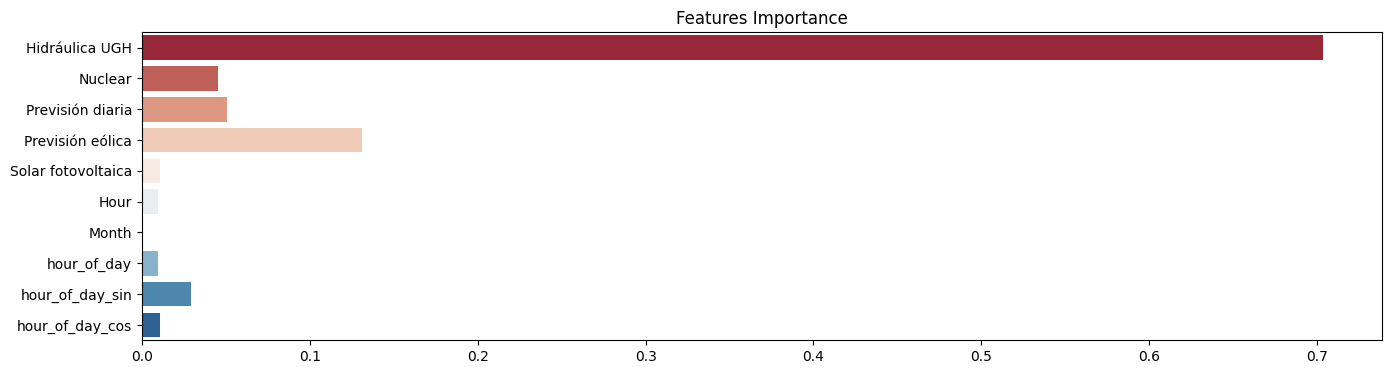

In [145]:
#feature importance in the prediction model
importances = final_model_Hourly_v1.feature_importances_
features = final_model_Hourly_v1.feature_names_in_

sns.barplot(x=importances, y=features, palette='RdBu')
plt.title('Features Importance')
plt.show()

## Plot the Predictions Vs the Real Values

In [146]:
prediction_plot(y_test, y_predict_Hourly_v1)

## Hourly and Minute Energy Price Prediction MAE and RMSE Scoes

In [147]:
pd.set_option('display.max_colwidth', 100) 
MAE_RMSE_Scores = pd.DataFrame({'MAE':[MAE_minute_1,MAE_hourly_1], 'RMSE':[RMSE_minute_1,RMSE_hourly_1]}, index=['Energy Price Quaterly Prediction', 'Energy Price Hourly Prediction'])
MAE_RMSE_Scores

MAE       RMSE
Energy Price Quaterly Prediction  21.195392  23.169180
Energy Price Hourly Prediction    19.814601  21.520335

Although both the quarterly prediction and the hourly prediction use the same features, their MAE and RMSE scores differ. These discrepancies may be due to the difference in sample size. The quarterly prediction has a larger sample size compared to the hourly prediction, which can lead to greater error between the test data and the predicted values.

# Predictive Modeling 2

Here, we are creating new features to improve the model. One type of feature we can add is lag variables. This prediction model uses a dataset with data recorded every fifteen minutes. To create an hourly energy prediction model, the dataset would need to be resampled to an hourly format. However, for now, we are developing a model using the 15-minute interval data with the added lagged variable features.

In [148]:
pivot['Lag_1_day'] = pivot['Mercado SPOT'].shift(96) #Lag of 24 hours (1 day)
pivot['Lag_2_days'] = pivot['Mercado SPOT'].shift(192) #Lag of 48 horurs (2 day)

In [149]:
pivot

name                 Hidráulica UGH  Mercado SPOT  Nuclear  Previsión diaria  \
datetime                                                                       
2023-12-31 23:00:00         626.950         63.33   1779.3           21981.0   
2023-12-31 23:15:00         647.975         63.33   1779.3           21863.0   
2023-12-31 23:30:00         625.850         63.33   1779.3           21807.0   
2023-12-31 23:45:00         625.850         63.33   1779.3           21767.0   
2024-01-01 00:00:00         663.125         50.09   1779.3           22640.0   
...                             ...           ...      ...               ...   
2024-01-31 21:45:00        1673.050         85.00   1779.3           29007.0   
2024-01-31 22:00:00        1588.950         77.52   1779.3           28070.0   
2024-01-31 22:15:00        1547.425         77.52   1779.3           27495.0   
2024-01-31 22:30:00        1547.425         77.52   1779.3           27003.0   
2024-01-31 22:45:00        1496.925         77.52   1779.3           26566.0   

name                 Previsión eólica  Solar fotovoltaica  Hour  Month  \
datetime                                                                 
2023-12-31 23:00:00            5218.0                 0.0    23     12   
2023-12-31 23:15:00            5198.0                 0.0    23     12   
2023-12-31 23:30:00            5175.0                 0.0    23     12   
2023-12-31 23:45:00            5147.0                 0.0    23     12   
2024-01-01 00:00:00            5299.0                 0.0     0      1   
...                               ...                 ...   ...    ...   
2024-01-31 21:45:00            4059.0                 0.0    21      1   
2024-01-31 22:00:00            4027.0                 0.0    22      1   
2024-01-31 22:15:00            4090.0                 0.0    22      1   
2024-01-31 22:30:00            4148.0                 0.0    22      1   
2024-01-31 22:45:00            4199.0                 0.0    22      1   

name                 hour_of_day  hour_of_day_sin  hour_of_day_cos  Lag_1_day  \
datetime                                                                        
2023-12-31 23:00:00     0.958333        -0.258819         0.965926        NaN   
2023-12-31 23:15:00     0.958333        -0.258819         0.965926        NaN   
2023-12-31 23:30:00     0.958333        -0.258819         0.965926        NaN   
2023-12-31 23:45:00     0.958333        -0.258819         0.965926        NaN   
2024-01-01 00:00:00     0.000000         0.000000         1.000000        NaN   
...                          ...              ...              ...        ...   
2024-01-31 21:45:00     0.875000        -0.707107         0.707107      88.70   
2024-01-31 22:00:00     0.916667        -0.500000         0.866025      78.78   
2024-01-31 22:15:00     0.916667        -0.500000         0.866025      78.78   
2024-01-31 22:30:00     0.916667        -0.500000         0.866025      78.78   
2024-01-31 22:45:00     0.916667        -0.500000         0.866025      78.78   

name                 Lag_2_days  
datetime                         
2023-12-31 23:00:00         NaN  
2023-12-31 23:15:00         NaN  
2023-12-31 23:30:00         NaN  
2023-12-31 23:45:00         NaN  
2024-01-01 00:00:00         NaN  
...                         ...  
2024-01-31 21:45:00       87.00  
2024-01-31 22:00:00       80.29  
2024-01-31 22:15:00       80.29  
2024-01-31 22:30:00       80.29  
2024-01-31 22:45:00       80.29  

[2976 rows x 13 columns]

## Correlation

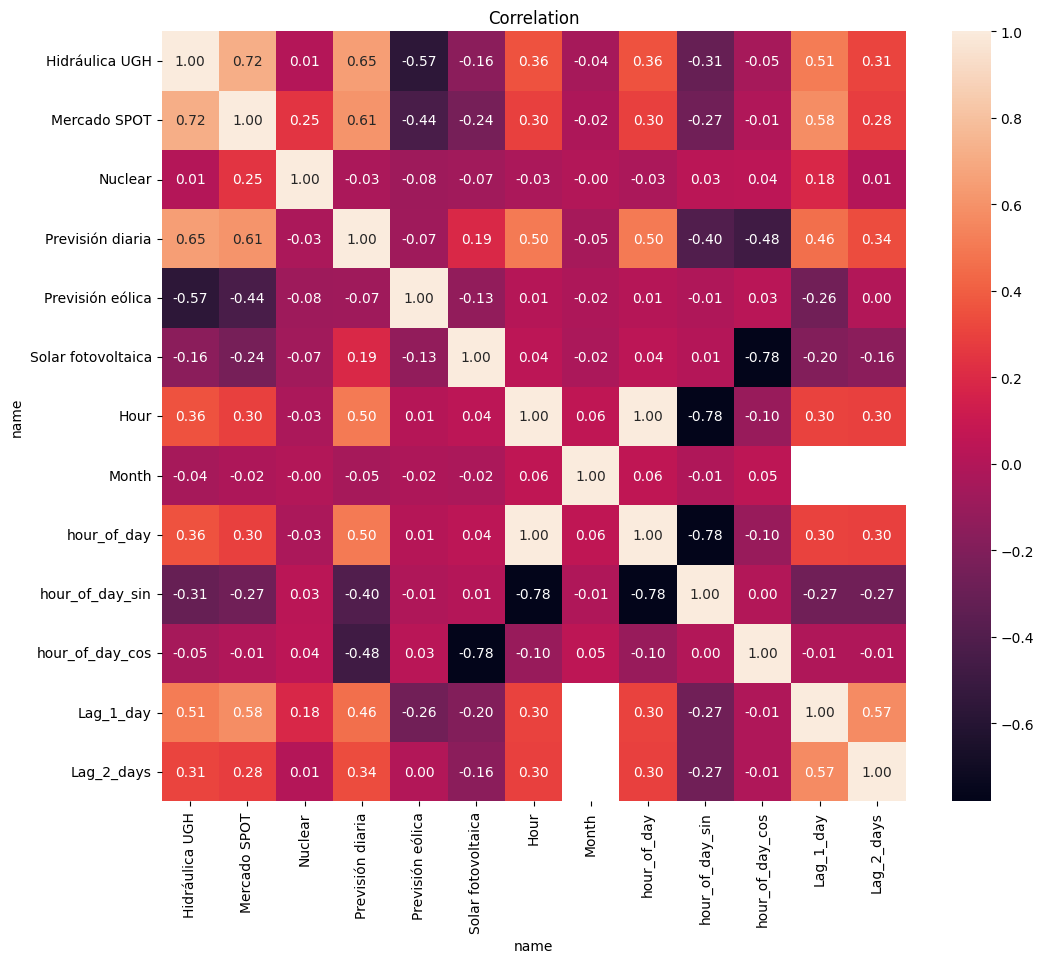

In [150]:
# Calculate the correlation matrix
corr = pivot.iloc[:,:].corr(method='pearson') 

# Plot Heat Map,
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f" )
plt.title('Correlation')
plt.show()

## Splitting the Data

In [151]:
# Splitting train and test data
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV, check_cv, cross_val_score, TimeSeriesSplit

df_ML_2 = pivot
df_ML_2.dropna(inplace=True)

# Features X, Target y
X = df_ML_2.drop(['Mercado SPOT'], axis=1)
y = df_ML_2['Mercado SPOT']
Train_split = 0.2

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=Train_split, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=Train_split, shuffle=False)


Scaling the Data

The model performs worse when the data are scaled, so I decided to remove scaling. Distance-based models, like linear regression, usually benefit from scaling, but tree-based models, such as Random Forest, XGBoost, and Decision Tree, often perform worse. Scaling can alter the original feature distribution.

In [152]:
'''scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)'''

'scaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_val_scaled = scaler.transform(X_val)\nX_test_scaled = scaler.transform(X_test)'

## Model Building and Evaluation

In [153]:
# num of folds and error metrics
num_of_folds = 5
error_metrics= {'neg_mean_squared_error','neg_mean_absolute_error','r2'}
metric_short = {'neg_mean_squared_error','neg_mean_absolute_error','r2'}


# models
models = {
    ('RFR', RandomForestRegressor()),
    ('XGB', XGBRegressor()), 
    ('LR', LinearRegression()),
    ('GBR', GradientBoostingRegressor()),
    ('DTR', DecisionTreeRegressor()),
}

##### Evaluation metric:  neg_mean_squared_error

Training model: LR with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: LinearRegression(), neg_mean_squared_error Men: -13672.5966, std:26684.2147


Training model: RFR with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: RandomForestRegressor(), neg_mean_squared_error Men: -391.2151, std:269.5795


Training model: DTR with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: DecisionTreeRegressor(), neg_mean_squared_error Men: -461.3588, std:287.6336


Training model: XGB with neg_mean_squared_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, ga

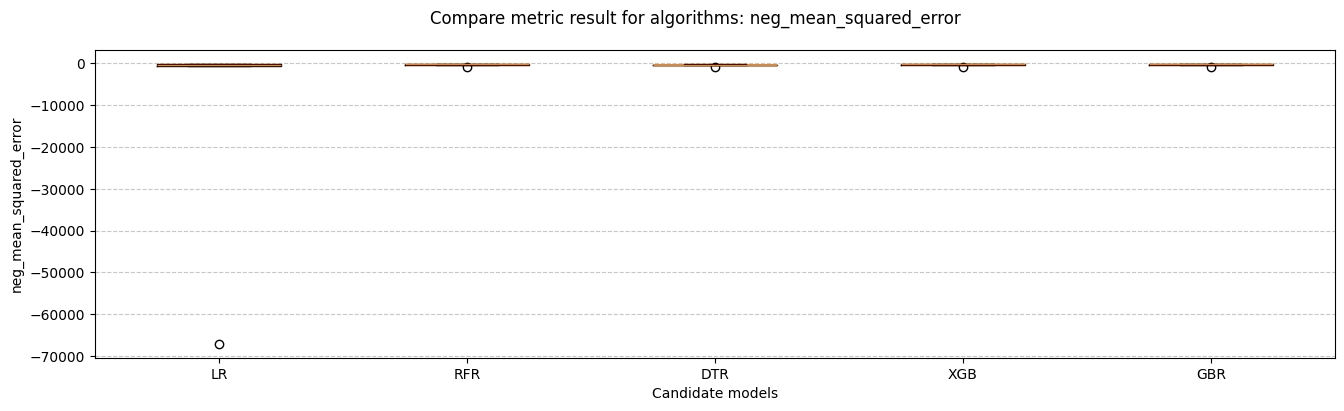

##### Evaluation metric:  neg_mean_absolute_error

Training model: LR with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: LinearRegression(), neg_mean_absolute_error Men: -41.7273, std:54.4011


Training model: RFR with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: RandomForestRegressor(), neg_mean_absolute_error Men: -14.8835, std:5.3937


Training model: DTR with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: DecisionTreeRegressor(), neg_mean_absolute_error Men: -16.2095, std:5.6195


Training model: XGB with neg_mean_absolute_error...
Perfroming TimeSeriesSplit with 5 folds...
Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=

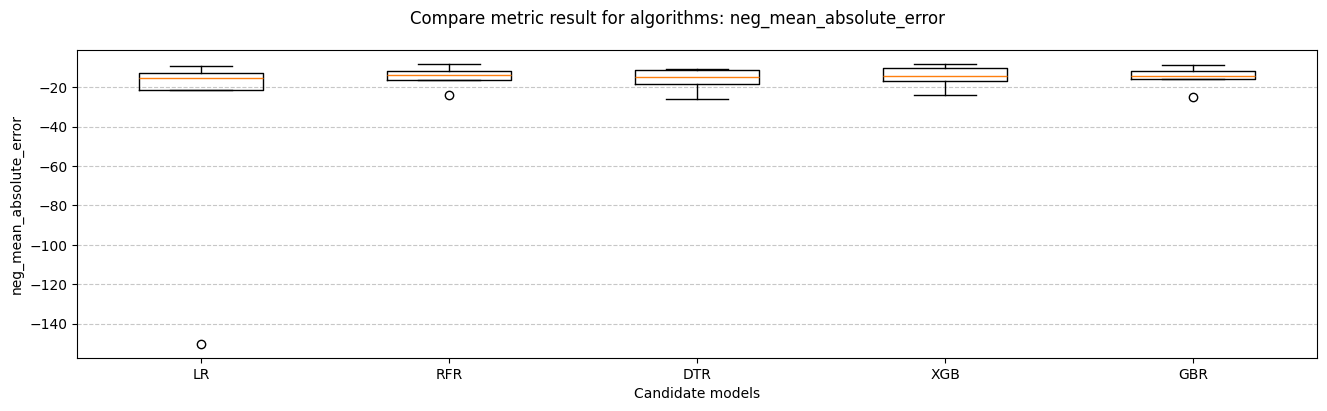

##### Evaluation metric:  r2

Training model: LR with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: LinearRegression(), r2 Men: -61.5459, std:124.0181


Training model: RFR with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: RandomForestRegressor(), r2 Men: 0.1927, std:0.4080


Training model: DTR with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: DecisionTreeRegressor(), r2 Men: -0.0266, std:0.5408


Training model: XGB with r2...
Perfroming TimeSeriesSplit with 5 folds...
Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
          

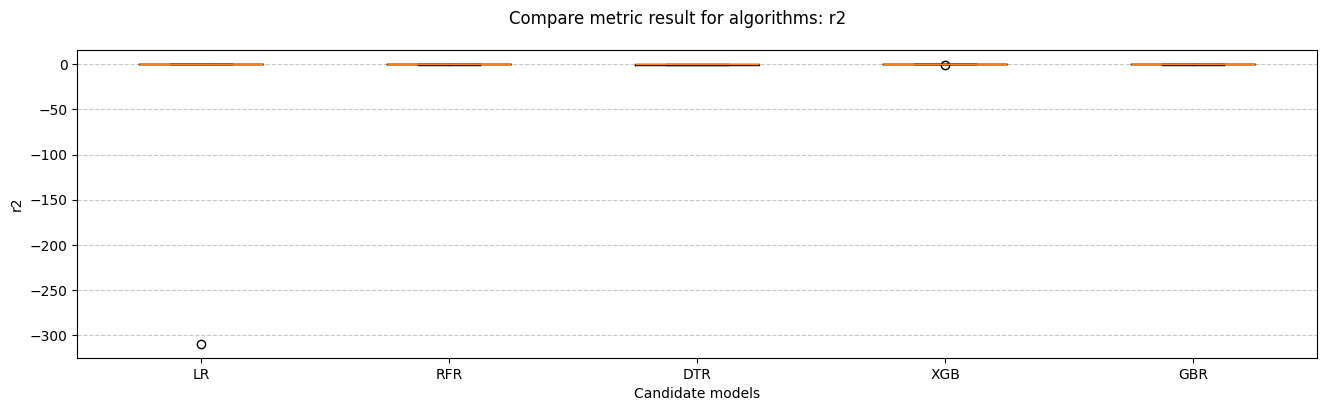

In [154]:
for scoring in error_metrics:
    results =[] # list of metric results
    msg=[] #list of summary of results
    names =[] #list of name of the models
    print('##### Evaluation metric: ', scoring)

    for name, model in models:
        print(f'\nTraining model: {name} with {scoring}...')
        cross_validation =TimeSeriesSplit(n_splits=num_of_folds)

        #start the cross-validation process and print verbose output
        print(f'Perfroming TimeSeriesSplit with {num_of_folds} folds...')

        cv_results = cross_val_score(model,X_train,y_train,cv=cross_validation,scoring=scoring)

        print(f'Model: {model}, {scoring} Men: {cv_results.mean():.4f}, std:{cv_results.std():.4f}\n')

        results.append(cv_results)
        names.append(name)
        resume = (name,cv_results.mean(), cv_results.std())
        msg.append(resume)

 # Compare results between algorithms
    fig = plt.figure()
    fig.suptitle('Compare metric result for algorithms: %s' %scoring)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Candidate models')
    ax.set_ylabel('%s' %scoring)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    # Show a grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

    results = []

## Best Model Hyper Parameters Adjustment

In [155]:
model = LinearRegression()
scoring='r2'
params = {'copy_X': [True,False], 
               'fit_intercept': [True,False], 
               'n_jobs': [1,5,10,15,None], 
               'positive': [True,False]}
   


# Search for the best combination of hyperparameters
cross_validation = TimeSeriesSplit(n_splits=5)
my_cv = cross_validation.split(X_val)
gsearch = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, cv=my_cv, verbose=3)
gsearch.fit(X_val, y_val)

# Print best Result
print("Best result: %f using the following hyperparameters %s" % (gsearch.best_score_, gsearch.best_params_))
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
params = gsearch.cv_results_['params']

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END copy_X=True, fit_intercept=True, n_jobs=1, positive=True;, score=0.581 total time=   0.0s
[CV 2/5] END copy_X=True, fit_intercept=True, n_jobs=1, positive=True;, score=0.810 total time=   0.0s
[CV 3/5] END copy_X=True, fit_intercept=True, n_jobs=1, positive=True;, score=-0.633 total time=   0.0s
[CV 4/5] END copy_X=True, fit_intercept=True, n_jobs=1, positive=True;, score=0.467 total time=   0.0s
[CV 5/5] END copy_X=True, fit_intercept=True, n_jobs=1, positive=True;, score=0.796 total time=   0.0s
[CV 1/5] END copy_X=True, fit_intercept=True, n_jobs=1, positive=False;, score=-0.160 total time=   0.0s
[CV 2/5] END copy_X=True, fit_intercept=True, n_jobs=1, positive=False;, score=0.787 total time=   0.0s
[CV 3/5] END copy_X=True, fit_intercept=True, n_jobs=1, positive=False;, score=-0.014 total time=   0.0s
[CV 4/5] END copy_X=True, fit_intercept=True, n_jobs=1, positive=False;, score=0.698 total time=   0.0s
[CV 

## Final Evaluation of the Model

In [156]:
# predict the test dataset
final_model_v2 = LinearRegression(copy_X= True, fit_intercept= False, n_jobs= 1, positive= False) # Model with the optimal parameters
final_model_v2.fit(X_train, y_train)
y_predict_v2 = final_model_v2.predict(X_test) # Making prediction

Evaluation Metrics for this final model (MAE, RMSE)

In [157]:
# Calculating MAE
MAE_minute_2 = mean_absolute_error(y_test, y_predict_v2)

# Calculating RMSE
MSE = mean_squared_error(y_test, y_predict_v2)
RMSE_minute_2 = np.sqrt(MSE)

print('Evaluation Metrics Results.....')
print('MAE: ', MAE_minute_2)
print('RMSE: ', RMSE_minute_2)

Evaluation Metrics Results.....
MAE:  16.30368560270632
RMSE:  18.103915282786293


## Plot prediction

In [158]:
prediction_plot(y_test, y_predict_v2)

## XGB

In [159]:
model = XGBRegressor()
scoring='r2'
params = {
    # Number of trees in random forest
    'n_estimators': [100, 500],  # default=100
    'max_depth': [2, None],  #deafult = None
}
   


# Search for the best combination of hyperparameters
cross_validation = TimeSeriesSplit(n_splits=5)
my_cv = cross_validation.split(X_val)
gsearch = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, cv=my_cv, verbose=3)
gsearch.fit(X_val, y_val)

# Print best Result
print("Best result: %f using the following hyperparameters %s" % (gsearch.best_score_, gsearch.best_params_))
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
params = gsearch.cv_results_['params']

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....max_depth=2, n_estimators=100;, score=0.715 total time=   0.0s
[CV 2/5] END .....max_depth=2, n_estimators=100;, score=0.524 total time=   0.0s
[CV 3/5] END .....max_depth=2, n_estimators=100;, score=0.058 total time=   0.0s
[CV 4/5] END .....max_depth=2, n_estimators=100;, score=0.633 total time=   0.0s
[CV 5/5] END .....max_depth=2, n_estimators=100;, score=0.579 total time=   0.0s
[CV 1/5] END .....max_depth=2, n_estimators=500;, score=0.716 total time=   0.1s
[CV 2/5] END .....max_depth=2, n_estimators=500;, score=0.478 total time=   0.1s
[CV 3/5] END .....max_depth=2, n_estimators=500;, score=0.038 total time=   0.2s
[CV 4/5] END .....max_depth=2, n_estimators=500;, score=0.605 total time=   0.1s
[CV 5/5] END .....max_depth=2, n_estimators=500;, score=0.567 total time=   0.1s
[CV 1/5] END ..max_depth=None, n_estimators=100;, score=0.515 total time=   0.0s
[CV 2/5] END ..max_depth=None, n_estimators=100;,

In [160]:
#get the best parameters in the model
best_params = gsearch.best_params_

In [161]:
# predict the test dataset
final_model_v3 = RandomForestRegressor(**best_params)
final_model_v3.fit(X_train,y_train)
y_predict_v3 = final_model_v3.predict(X_test)

In [162]:
# Calculating MAE
MAE_minute_2_2 = mean_absolute_error(y_test, y_predict_v3)

# Calculating RMSE
MSE = mean_squared_error(y_test, y_predict_v3)
RMSE_minute_2_2 = np.sqrt(MSE)

print('Evaluation Metrics Results.....')
print('MAE: ', MAE_minute_2_2)
print('RMSE: ', RMSE_minute_2_2)

Evaluation Metrics Results.....
MAE:  20.344153813790513
RMSE:  23.085640386716747


## Plot prediction

In [163]:
prediction_plot(y_test, y_predict_v3)

An interesting finding here is that the predicted price did not fall below 80 €/MWh. This could be due to model bias, which prevents it from capturing the low-price events.

Feature Importance

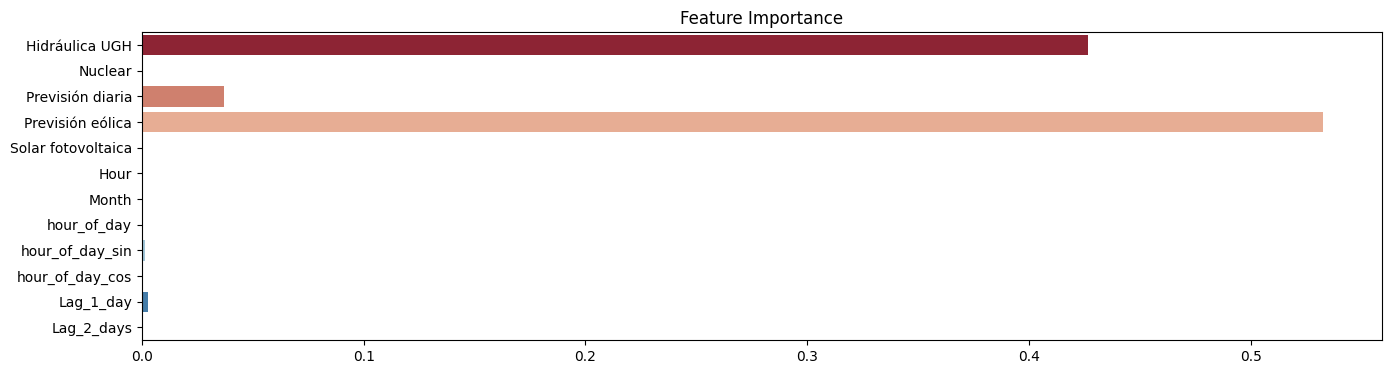

In [164]:
importances = final_model_v3.feature_importances_
features = final_model_v3.feature_names_in_

sns.barplot(x=importances, y=features, palette='RdBu')
plt.title('Feature Importance')
plt.show()

## Model 2 Linear Regression and XGB MAE and RMSE Scores

In [165]:
pd.set_option('display.max_colwidth', 100) 
MAE_RMSE_Scores = pd.DataFrame({'MAE':[MAE_minute_2,MAE_minute_2_2], 'RMSE':[RMSE_minute_2,RMSE_minute_2_2]}, index=['LR', 'XGB'])
MAE_RMSE_Scores

MAE       RMSE
LR   16.303686  18.103915
XGB  20.344154  23.085640

The comparison of MAE and RMSE scores shows that the Linear Regression (LR) model performs well.

In [166]:
Pipleline_2 = make_pipeline(final_model_v2)
print(Pipleline_2.fit(X_train,y_train))
print(Pipleline_2.score(X_train,y_train))
print(Pipleline_2.score(X_test,y_test))


Pipeline(steps=[('linearregression',
                 LinearRegression(fit_intercept=False, n_jobs=1))])
0.7971578473471882
0.10210379638663014


In [167]:
joblib.dump(final_model_v2,'Energy_price_prediction_v2')

['Energy_price_prediction_v2']

# Optimization and Automation Concept

**Optimization**

* Inputs: Predicted Energy Price

* Variables

    1. Decision variables: Charging power and discharging power
    2. Defined variables: Charging and discharging efficiency of the thermal storage

* Contraints: 

    1. Power Constraint: Keep the charging ahd discharging power of the thermal storage within the defined boundary limits.
    2. State of Charge of the thermal Stoarge: Keep the thermal storage state of charge within its allowable boundary range.

* Objective Function: 

Cost Minimization

Minimization = Summation (Charging Power(t) * Market Spot price (Buying price) + operational cost) for t = 1 to T = 24

**Logic**: Run the optimization every hour to determine the scheduled energy purchases for the next 24 hours, with the objective of minimizing cost.

**Real-Time Automation + ESIOS Integration**

* 1. Get Real Time Data using an API
* 2. Retrain Model
* 3. Forecast Energy Price
* 5. Solve Optimization Problem
* 6. Send a control signal to the Thermal Energy Storage (TES) specifying the charging schedule for the next hour.

## Optionally describe how this could be deployed in a cloud workflow (e.g., using BigQuery, Vertex AI, or scheduled Python scripts).

In Vertex AI
* Ingest (Import data from using BigQuery)
* Analyze
* Transform
* Train
* Model (Use the custom energy price prediction model we build)
* Evaluate
* Deploy
* Predict (Predict Energy Price)
* Run optimization

Finally, send commands to the thermal energy storage through the interface connecting the optimizer and the storage system.

# API Request 

***(for self practice)***

In [ ]:
API_TOKEN = 'TU_TOKEN'

headers = {
    'Host': 'api.esios.ree.es',
    'x-api-key': '..'  #your API Key
}


URL_BASE = 'https://api.esios.ree.es/'
ENDPOINT = 'indicators/'

url = URL_BASE + ENDPOINT

import requests
import pandas as pd

res = requests.get(url, headers=headers)
data = res.json()

INDICATOR = '1'
url = URL_BASE + ENDPOINT + INDICATOR


res = requests.get(url, headers=headers)
data = res.json()


In [173]:
res.content

b'{\n  "indicator": {\n    "name": "Generaci\xc3\xb3n programada PBF Hidr\xc3\xa1ulica UGH",\n    "short_name": "Hidr\xc3\xa1ulica UGH",\n    "id": 1,\n    "composited": false,\n    "step_type": "step",\n    "disaggregated": false,\n    "magnitud": [\n      {\n        "name": "Energ\xc3\xada",\n        "id": 13\n      }\n    ],\n    "tiempo": [\n      {\n        "name": "Hora",\n        "id": 4\n      }\n    ],\n    "geos": [\n      {\n        "geo_id": 8741,\n        "geo_name": "Pen\xc3\xadnsula"\n      }\n    ],\n    "values_updated_at": "2025-11-26T14:38:44.000+01:00",\n    "values": [\n      {\n        "value": 3834.2,\n        "datetime": "2025-11-27T00:00:00.000+01:00",\n        "datetime_utc": "2025-11-26T23:00:00Z",\n        "tz_time": "2025-11-26T23:00:00.000Z",\n        "geo_id": 8741,\n        "geo_name": "Pen\xc3\xadnsula"\n      },\n      {\n        "value": 3377.9,\n        "datetime": "2025-11-27T01:00:00.000+01:00",\n        "datetime_utc": "2025-11-27T00:00:00Z",\n   

In [174]:
data

{'indicator': {'name': 'Generación programada PBF Hidráulica UGH',
  'short_name': 'Hidráulica UGH',
  'id': 1,
  'composited': False,
  'step_type': 'step',
  'disaggregated': False,
  'magnitud': [{'name': 'Energía', 'id': 13}],
  'tiempo': [{'name': 'Hora', 'id': 4}],
  'geos': [{'geo_id': 8741, 'geo_name': 'Península'}],
  'values_updated_at': '2025-11-26T14:38:44.000+01:00',
  'values': [{'value': 3834.2,
    'datetime': '2025-11-27T00:00:00.000+01:00',
    'datetime_utc': '2025-11-26T23:00:00Z',
    'tz_time': '2025-11-26T23:00:00.000Z',
    'geo_id': 8741,
    'geo_name': 'Península'},
   {'value': 3377.9,
    'datetime': '2025-11-27T01:00:00.000+01:00',
    'datetime_utc': '2025-11-27T00:00:00Z',
    'tz_time': '2025-11-27T00:00:00.000Z',
    'geo_id': 8741,
    'geo_name': 'Península'},
   {'value': 3282.4,
    'datetime': '2025-11-27T02:00:00.000+01:00',
    'datetime_utc': '2025-11-27T01:00:00Z',
    'tz_time': '2025-11-27T01:00:00.000Z',
    'geo_id': 8741,
    'geo_name': 

In [175]:
df_esios = pd.DataFrame(data['indicator']['values'])
df_esios = df_esios[['datetime_utc', 'geo_id', 'geo_name', 'value']]

In [176]:
params = {
    'start_date': '2024-01-01T00',
    'end_date': '2024-01-31T23'
}

res = requests.get(url, headers=headers, params=params)

In [177]:
df_esios['datetime_utc'] = pd.to_datetime(df_esios['datetime_utc']).dt.tz_localize(None)

In [178]:
df_esios.set_index('datetime_utc',inplace=True)

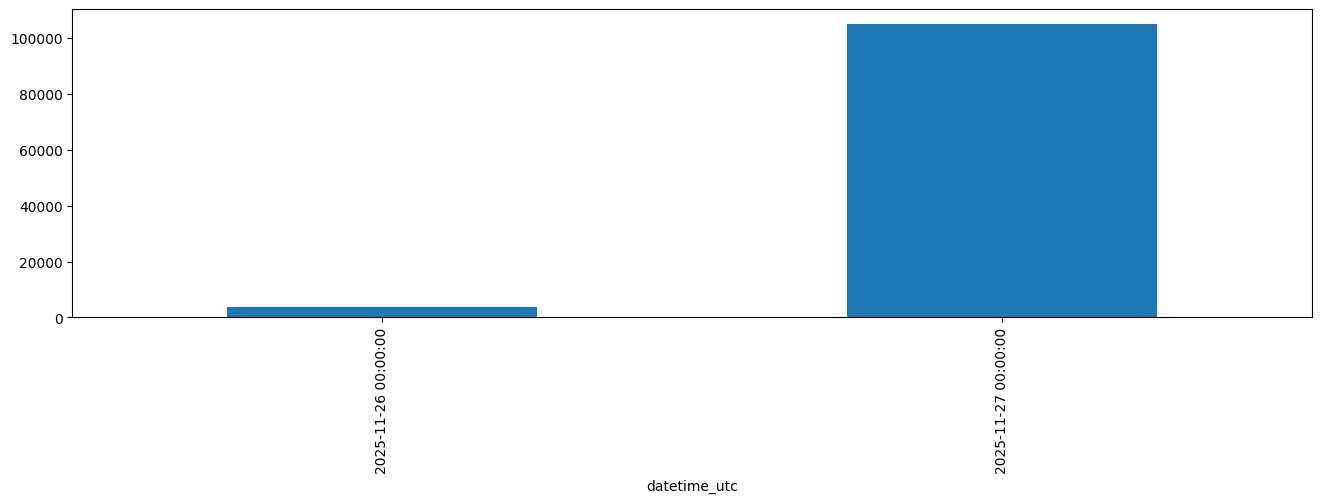

In [179]:
df_esios.resample(rule='D').value.sum().plot(kind='bar')
df_esios.to_excel('data.xlsx')

In [180]:
df_esios


geo_id   geo_name   value
datetime_utc                                  
2025-11-26 23:00:00    8741  Península  3834.2
2025-11-27 00:00:00    8741  Península  3377.9
2025-11-27 01:00:00    8741  Península  3282.4
2025-11-27 02:00:00    8741  Península  2753.8
2025-11-27 03:00:00    8741  Península  2750.2
2025-11-27 04:00:00    8741  Península  3197.7
2025-11-27 05:00:00    8741  Península  4565.3
2025-11-27 06:00:00    8741  Península  6581.6
2025-11-27 07:00:00    8741  Península  6603.8
2025-11-27 08:00:00    8741  Península  6004.0
2025-11-27 09:00:00    8741  Península  3208.1
2025-11-27 10:00:00    8741  Península  1712.1
2025-11-27 11:00:00    8741  Península  1616.1
2025-11-27 12:00:00    8741  Península  1631.8
2025-11-27 13:00:00    8741  Península  1672.9
2025-11-27 14:00:00    8741  Península  2631.4
2025-11-27 15:00:00    8741  Península  3939.6
2025-11-27 16:00:00    8741  Península  5947.4
2025-11-27 17:00:00    8741  Península  7214.4
2025-11-27 18:00:00    8741  Península  7415.8
2025-11-27 19:00:00    8741  Península  7969.3
2025-11-27 20:00:00    8741  Península  8056.7
2025-11-27 21:00:00    8741  Península  6924.9
2025-11-27 22:00:00    8741  Península  6072.3